# Test Variational Inference algorithms for Wold processes

In this notebook, we test the various variational inference (VI) algorithms implemented for the multivariate Wold process. Namely:

* `WoldModelVariational`: VI with parameters $\alpha$ and $\beta$

with the **new updates** involving solving a set of 2d^2 1-dimensional equations.

---

Load extensions for debugging

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

Import the libraries of interest for this notebook

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

import itertools
import torch
import numpy as np

# Set numpy print format
np.set_printoptions(precision=2, floatmode='fixed', sign=' ')

import tsvar

---

## Generate toy example dataset


### V1. Small 2-dimensional toy setting

### V2. Larger setting

In [3]:
from experiments_utils import generate_parameters

dim = 5
# max_jumps = 5e3 * dim
max_jumps = int(1e4)

param_dict = generate_parameters(dim=dim, base_range=[0.05, 0.05], adj_range=[0.1, 0.2])

mu = torch.tensor(param_dict['baseline'])
beta = torch.tensor(param_dict['beta'])
alpha = torch.tensor(param_dict['adjacency'])

print('Baseline:')
print(mu.numpy().round(2))
print('Alpha:')
print(alpha.numpy().round(2))
print('Beta:')
print(beta.numpy().round(2))

Baseline:
[ 0.05  0.05  0.05  0.05  0.05]
Alpha:
[[ 0.16  0.17  0.18  0.19  0.18]
 [ 0.14  0.18  0.13  0.00  0.00]
 [ 0.17  0.00  0.00  0.18  0.18]
 [ 0.16  0.19  0.14  0.18  0.00]
 [ 0.13  0.18  0.18  0.17  0.17]]
Beta:
[[ 0.82  0.51  0.13  0.21  0.63]
 [ 0.91  0.69  0.21  0.21  0.04]
 [ 0.18  0.17  0.18  0.90  0.13]
 [ 0.76  0.77  0.41  0.33  0.21]
 [ 0.28  0.63  0.66  0.71  0.61]]


### Simulate a realization

In [4]:
coeffs_true = torch.cat((mu, beta.flatten(), alpha.flatten())).numpy()
print('  - Simulate lots of data...')
# Simulate lots of data
wold_sim = tsvar.simulate.MultivariateWoldSimulator(
    mu_a=mu, alpha_ba=alpha, beta_ba=beta)
events = wold_sim.simulate(max_jumps=max_jumps, seed=None)
events = [torch.tensor(ev, dtype=torch.float) for ev in events]
end_time = max(map(max, events))
print((f"    - Simulated {sum(map(len, events)):,d} events "
       f"with end time: {end_time}"))
print("    - Events:")
for i, events_i in enumerate(events):
    print(f"      - dim {i:>2d} ({len(events_i):>5d} events):", events_i.numpy())

  - Simulate lots of data...
    - Simulated 10,000 events with end time: 9903.283203125
    - Events:
      - dim  0 ( 2193 events): [    6.00     9.57     9.97 ...  9895.56  9898.86  9900.08]
      - dim  1 ( 2061 events): [    6.78     9.54    20.28 ...  9886.10  9890.66  9899.38]
      - dim  2 ( 2018 events): [   10.60    11.19    18.73 ...  9867.59  9877.77  9891.08]
      - dim  3 ( 2080 events): [    4.15    20.93    27.35 ...  9890.09  9902.74  9903.28]
      - dim  4 ( 1648 events): [   25.02    36.47    42.65 ...  9875.28  9900.29  9900.55]


---

## Test Mean-Field VI with Variable $\{\beta\}$s using `WoldModelVariational`

Define the parameters of the prior.

In [5]:
# Set priors
# prior: Alpha
as_pr = 0.1 * np.ones((dim + 1, dim))
ar_pr = 1.0 * np.ones((dim + 1, dim))

# prior: Beta
bs_pr = 10.0 * np.ones((dim, dim))
br_pr = 10.0 * np.ones((dim, dim))

# prior: Z
zc_pr = [1.0 * np.ones((len(events[i]), dim+1)) for i in range(dim)]

print('ALPHA:')
print('------')
print('mean')
print(as_pr / ar_pr)
print('variance')
print(as_pr / ar_pr ** 2)

print('BETA:')
print('-----')
print('mean')
print(br_pr / (bs_pr - 1))
print('variance')
print(br_pr**2 / ((bs_pr - 1)**2 * (bs_pr - 2)))

ALPHA:
------
mean
[[ 0.10  0.10  0.10  0.10  0.10]
 [ 0.10  0.10  0.10  0.10  0.10]
 [ 0.10  0.10  0.10  0.10  0.10]
 [ 0.10  0.10  0.10  0.10  0.10]
 [ 0.10  0.10  0.10  0.10  0.10]
 [ 0.10  0.10  0.10  0.10  0.10]]
variance
[[ 0.10  0.10  0.10  0.10  0.10]
 [ 0.10  0.10  0.10  0.10  0.10]
 [ 0.10  0.10  0.10  0.10  0.10]
 [ 0.10  0.10  0.10  0.10  0.10]
 [ 0.10  0.10  0.10  0.10  0.10]
 [ 0.10  0.10  0.10  0.10  0.10]]
BETA:
-----
mean
[[ 1.11  1.11  1.11  1.11  1.11]
 [ 1.11  1.11  1.11  1.11  1.11]
 [ 1.11  1.11  1.11  1.11  1.11]
 [ 1.11  1.11  1.11  1.11  1.11]
 [ 1.11  1.11  1.11  1.11  1.11]]
variance
[[ 0.15  0.15  0.15  0.15  0.15]
 [ 0.15  0.15  0.15  0.15  0.15]
 [ 0.15  0.15  0.15  0.15  0.15]
 [ 0.15  0.15  0.15  0.15  0.15]
 [ 0.15  0.15  0.15  0.15  0.15]]


Fit the model.

In [7]:
class MyCallback(tsvar.utils.callbacks.LearnerCallbackMLE):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.extra = {'bs_po':[], 'br_po':[], 'as_po':[], 'ar_po':[], 'zp_po': []}
    
    def __call__(self, obj, **kwargs):
        super().__call__(obj, **kwargs)
        self.extra['bs_po'].append(obj._bs_po)
        self.extra['br_po'].append(obj._br_po)
        self.extra['as_po'].append(obj._as_po)
        self.extra['ar_po'].append(obj._ar_po)
        self.extra['zp_po'].append(obj._zp_po)
        
# Set callback to monitor progress
coeffs_start = alpha.numpy().flatten().copy()
callback = MyCallback(x0=coeffs_start,print_every=10, 
                      coeffs_true=alpha.numpy().flatten(), 
                      acc_thresh=0.05, dim=dim, default_end='\n')

# Set model & observations
vi_model = tsvar.models.WoldModelVariational(verbose=True)
vi_model.observe(events)

# Fit model
vi_model.fit(as_pr=as_pr, ar_pr=ar_pr, bs_pr=bs_pr, br_pr=br_pr, zc_pr=zc_pr, 
             max_iter=2500, tol=1e-5, callback=callback)

iter:    10 | dx: +4.4583e-03 | acc: 0.80 | f1-score: 0.89 | relerr: 2.50e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 4.67e+00     
iter:    20 | dx: +2.2282e-03 | acc: 0.84 | f1-score: 0.91 | relerr: 2.36e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 1.43e-02     
iter:    30 | dx: +1.3584e-03 | acc: 0.92 | f1-score: 0.95 | relerr: 2.31e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 1.74e-02     
iter:    40 | dx: +9.0703e-04 | acc: 0.96 | f1-score: 0.98 | relerr: 2.28e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 1.43e-02     
iter:    50 | dx: +6.3280e-04 | acc: 0.96 | f1-score: 0.98 | relerr: 2.28e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 1.41e-02     
iter:    60 | dx: +4.6259e-04 | acc: 0.96 | f1-score: 0.98 | relerr: 2.28e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 1.43e-02     
iter:    70 | dx: +3.5803e-04 | acc: 0.96 | f1-score: 0.98 | relerr: 2.29e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 1.47e-02     
iter:    80 |

iter:   600 | dx: +9.9148e-06 | acc: 1.00 | f1-score: 1.00 | relerr: 2.28e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 1.86e-02     
iter:   610 | dx: +6.6556e-06 | acc: 1.00 | f1-score: 1.00 | relerr: 2.28e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 1.84e-02     
iter:   620 | dx: +1.4289e-05 | acc: 1.00 | f1-score: 1.00 | relerr: 2.28e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 2.04e-02     
iter:   630 | dx: +1.1040e-05 | acc: 1.00 | f1-score: 1.00 | relerr: 2.28e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 1.99e-02     
iter:   640 | dx: +7.4491e-06 | acc: 1.00 | f1-score: 1.00 | relerr: 2.28e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 1.76e-02     
*** KeyboardInterrupt exception caught in code being profiled.

In [30]:
np.where(vi_model._bs_po < 0)

(array([1, 4]), array([4, 4]))

In [24]:
j = 2
i = 4

In [25]:
#vi_model.fit(as_pr=as_pr, ar_pr=ar_pr, bs_pr=bs_pr, br_pr=br_pr, zc_pr=zc_pr, max_iter=0, tol=1e-5)

vi_model._init_fit(as_pr=as_pr, ar_pr=ar_pr, bs_pr=bs_pr, br_pr=br_pr, zc_pr=zc_pr)
vi_model._as_po, vi_model._ar_po = tsvar.models._wold_var_stochastic._update_alpha(
    as_pr=vi_model._as_pr, ar_pr=vi_model._ar_pr, zp_po=vi_model._zp_po,
    bs_po=vi_model._bs_po, br_po=vi_model._br_po, dt_ik=vi_model.dt_ik,
    delta_ikj=vi_model.delta_ikj, valid_mask_ikj=vi_model.valid_mask_ikj)

In [26]:
kwargs = {'bs_pr': vi_model._bs_pr, 'br_pr': vi_model._br_pr, 
          'as_po': vi_model._as_po, 'ar_po': vi_model._ar_po, 
          'zp_po': vi_model._zp_po, 'dts': vi_model.dt_ik, 
          'delta': vi_model.delta_ikj, 'valid_mask': vi_model.valid_mask_ikj}

x = np.linspace(0.01, 10.0, 100)
n = 0

y = np.zeros_like(x)
dy = np.zeros_like(x)
dy2 = np.zeros_like(x)

for ii, xx in enumerate(x):
    y[ii], dy[ii], dy2[ii] = tsvar.models._wold_var_stochastic._beta_funcs(xx, j=j, i=i, n=n, **kwargs)

10.0


(-2000.0, 50)

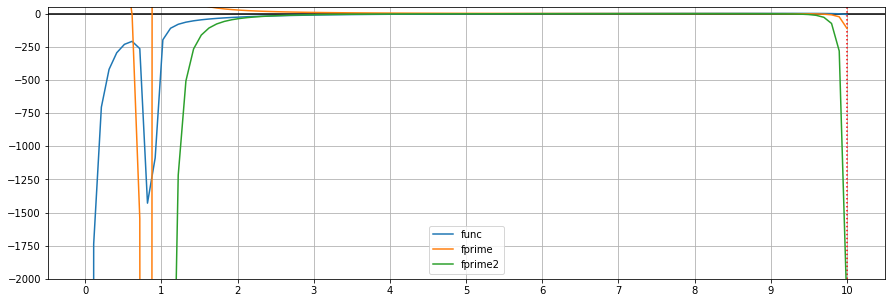

In [27]:
plt.figure(figsize=(15, 5))
plt.grid()

root = x[y < 0][-1]
print(root)
plt.axvline(root, c='r', ls=':')
plt.axhline(0.0, c='k', ls='-')

plt.plot(x, y, c='C0', label='func')
plt.plot(x, dy, c='C1', label="fprime")
plt.plot(x, dy2, c='C2', label='fprime2')

plt.xticks(np.arange(0, 10.1, 1))
plt.legend()

plt.ylim(bottom=-2000.0, top=50)

In [14]:
%time val_halley = tsvar.models._wold_var_stochastic.solve_halley(xstart=0.01, max_iter=10, tol=1e-5, j=j, i=i, n=n, **kwargs)

print(val_halley)
tsvar.models._wold_var_stochastic._beta_funcs(x=val_halley, j=j, i=i, n=n, **kwargs)

CPU times: user 900 ms, sys: 18.9 ms, total: 918 ms
Wall time: 1.02 s
3.756447340423636


(-2.069499056567281e-07, 18.23978927432922, -39.465776037531114)

In [15]:
%time val_bs = tsvar.models._wold_var_stochastic.solve_binary_search(x_min=0.01, x_max=50.0, max_iter=15, tol=1e-2, j=j, i=i, n=n, **kwargs)

print(val_bs)
tsvar.models._wold_var_stochastic._beta_funcs(x=val_bs, j=j, i=i, n=n, **kwargs)

CPU times: user 3.87 s, sys: 46.4 ms, total: 3.92 s
Wall time: 3.95 s
4.878105773925782


(-0.21617787772283137, 155.55086922855145, -1569.569918175321)

In [16]:
%time val_nt = tsvar.models._wold_var_stochastic.solve_newton(xstart=0.1, max_iter=10, tol=1e-2, j=j, i=i, n=n, **kwargs)

print(val_nt)
tsvar.models._wold_var_stochastic._beta_funcs(x=val_nt, j=j, i=i, n=n, **kwargs)

CPU times: user 807 ms, sys: 15.1 ms, total: 822 ms
Wall time: 822 ms
3.755306238486294


(-0.020839341970039116, 18.28477561943905, -39.38154640994855)